Data exploratoin, plot scatter plots to view

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the data
file_path = "/Users/spotter/Documents/new_combustion/2025-06-23_LC_FISL_Original_combustionModelPredictors.csv"
df = pd.read_csv(file_path)

# Drop rows with any missing values
df_clean = df.dropna()

# Columns to exclude from predictor variables
exclude_columns = [
    'above.carbon.combusted', 
    'below.ground.carbon.combusted', 
    'burn.depth',
    'burn_year', 
    'project.name', 
    'latitude', 
    'longitude', 
    'Date',
    'id'
    'CNA_MAR'
]

# Get list of independent (predictor) variables
independent_vars = [col for col in df_clean.columns if col not in exclude_columns]

# Define output directory
output_dir = os.path.expanduser("/Users/spotter/Documents/new_combustion/above_scatter_plots")
os.makedirs(output_dir, exist_ok=True)

# Generate and save scatter plots
for var in independent_vars:
    plt.figure(figsize=(6, 4))
    plt.scatter(df_clean[var], df_clean['above.carbon.combusted'], alpha=0.6)
    plt.xlabel(var)
    plt.ylabel('above.carbon.combusted')
    plt.title(f'{var} vs above.carbon.combusted')
    plt.tight_layout()
    output_file = os.path.join(output_dir, f"{var}_vs_above_carbon_combusted.png")
    plt.savefig(output_file)
    plt.close()


Recursive feature elimination for aboveground

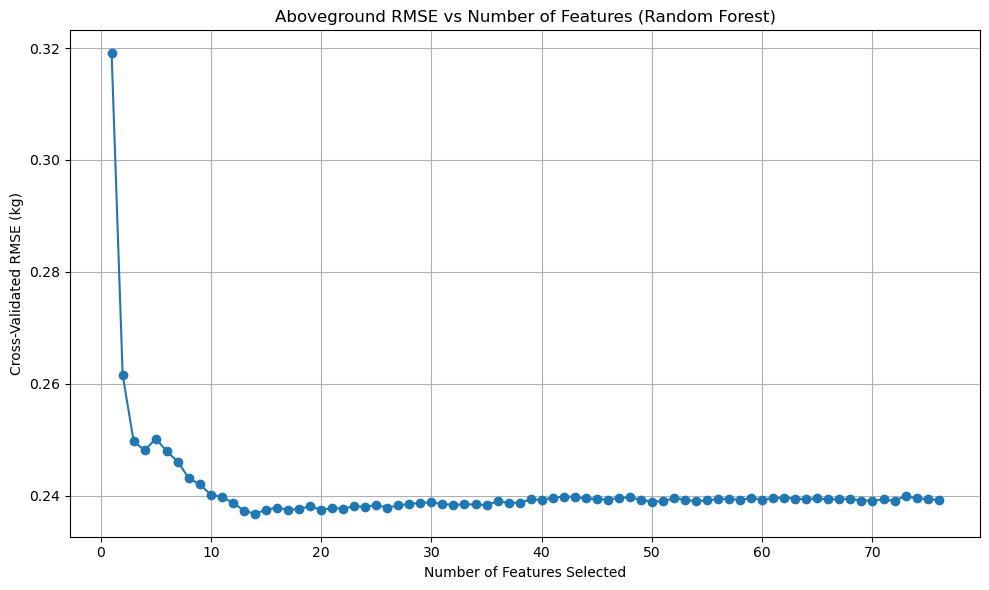

Optimal number of features: 1
Selected features: ['NDII']

Top 10 most important features (full model):
1. Tree.cover (importance: 0.1207)
2. wetness (importance: 0.0565)
3. CNA_EMT (importance: 0.0486)
4. NDII (importance: 0.0473)
5. brightness (importance: 0.0403)
6. greenness (importance: 0.0388)
7. CNA_PPT_5_8 (importance: 0.0252)
8. Clay_30 (importance: 0.0230)
9. BD_30 (importance: 0.0223)
10. rbr (importance: 0.0218)


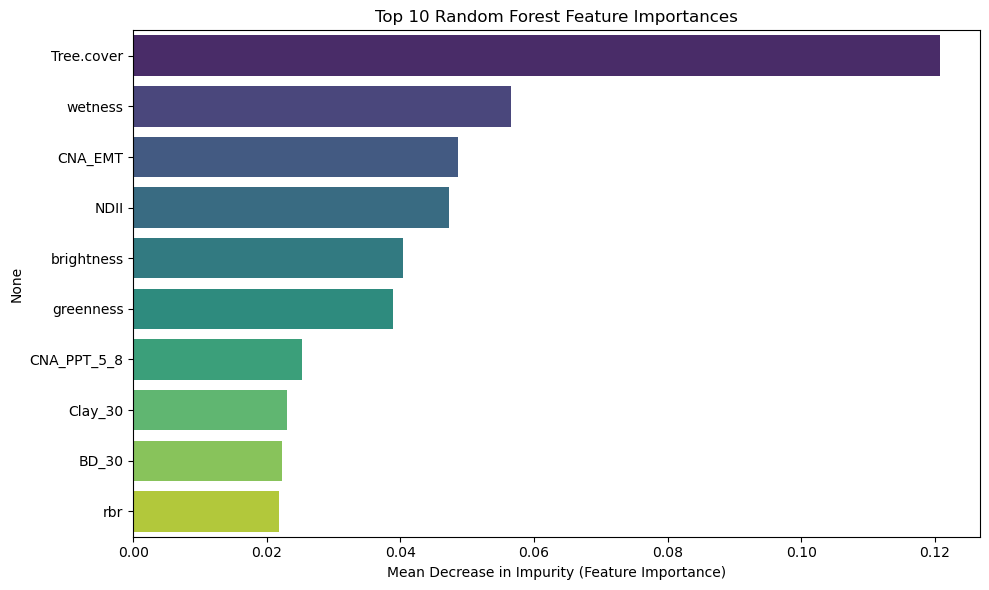

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 1. Load and clean data
df = pd.read_csv("/Users/spotter/Documents/new_combustion/2025-06-23_LC_FISL_Original_combustionModelPredictors.csv")

# 2. Exclude columns not relevant for modeling
exclude_columns = [
    'below.ground.carbon.combusted',
    'burn.depth',
    'burn_year',
    'project.name',
    'latitude',
    'longitude',
    'Date',
    'id',
    'CNA_MAR'
]

# 3. Drop excluded columns and NaNs
df_clean = df.drop(columns=exclude_columns).dropna()

# 4. Define target (y) and predictors (X) — exclude y from X
y = df_clean['above.carbon.combusted'] / 1000  # g to kg
X = df_clean.drop(columns=['above.carbon.combusted'])

# 5. Set up scorer and model
rmse_scorer = make_scorer(mean_squared_error, squared=False)
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 6. Run RFECV
rfecv = RFECV(estimator=rf, step=1, cv=cv, scoring=rmse_scorer, n_jobs=-1)
rfecv.fit(X, y)

# 7. Plot CV RMSE vs number of features
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    rfecv.cv_results_['mean_test_score'],
    marker='o'
)
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validated RMSE (kg)")
plt.title("Aboveground RMSE vs Number of Features (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Print optimal features
selected_features = list(X.columns[rfecv.support_])
print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", selected_features)


# 9. Train full model to get top 10 global feature importances
full_rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
full_rf.fit(X, y)
full_importances = pd.Series(full_rf.feature_importances_, index=X.columns)
top_10_features = full_importances.sort_values(ascending=False).head(10)

# Print top 10
print("\nTop 10 most important features (full model):")
for i, (name, value) in enumerate(top_10_features.items(), 1):
    print(f"{i}. {name} (importance: {value:.4f})")

# 10. Create a new DataFrame with only the top 10 features
top_10_df_above = X[top_10_features.index].copy()

# 11. Plot top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette="viridis")
plt.xlabel("Mean Decrease in Impurity (Feature Importance)")
plt.title("Top 10 Random Forest Feature Importances")
plt.tight_layout()
plt.show()


SHAP values aboveground

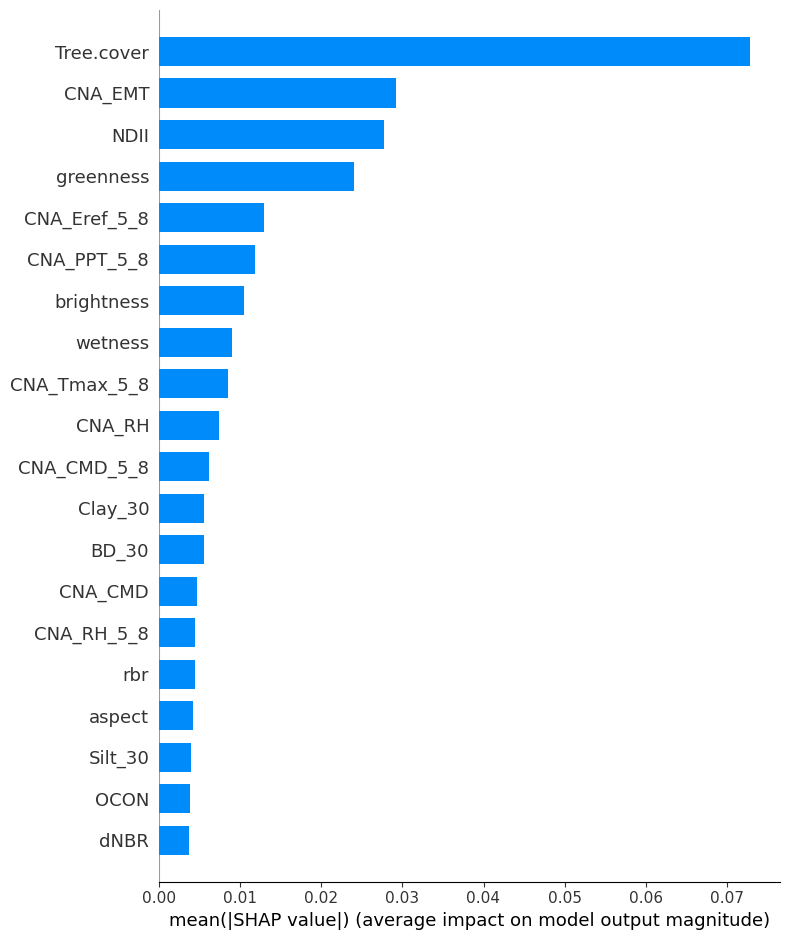

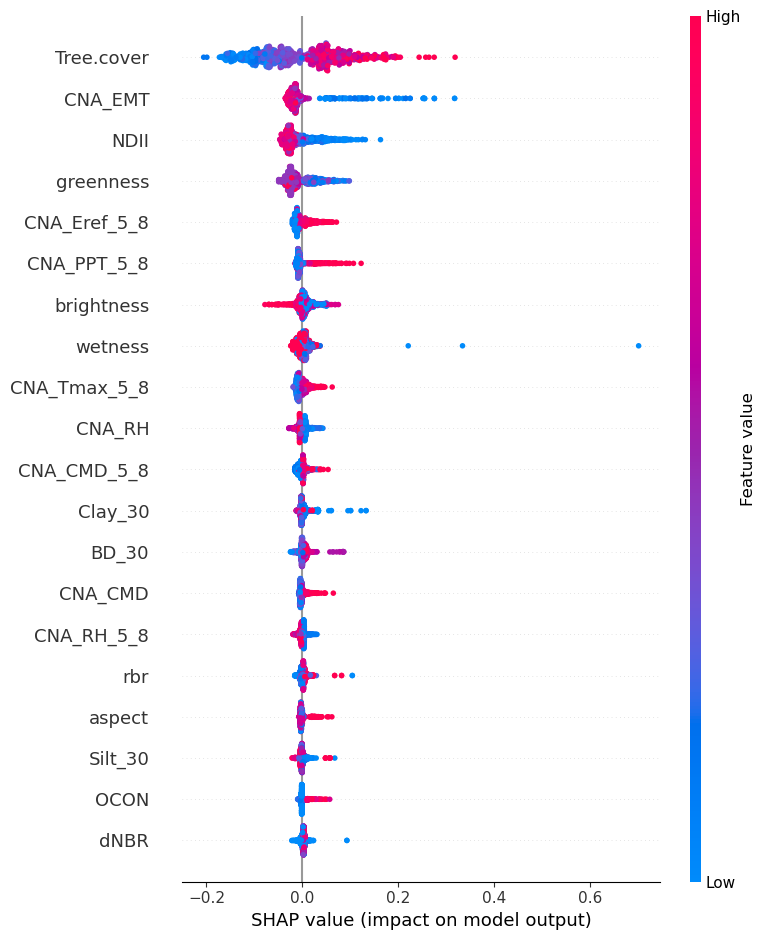

In [19]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 1. Load and clean data
df = pd.read_csv("/Users/spotter/Documents/new_combustion/2025-06-23_LC_FISL_Original_combustionModelPredictors.csv")
exclude_columns = [
    'below.ground.carbon.combusted',
    'burn.depth',
    'burn_year',
    'project.name',
    'latitude',
    'longitude',
    'Date',
    'id',
    'CNA_MAR'
]
df_clean = df.drop(columns=exclude_columns).dropna()

# 2. Split into X and y
y = df_clean['above.carbon.combusted'] / 1000  # g to kg
X = df_clean.drop(columns=['above.carbon.combusted'])

# 3. Fit Random Forest model
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(X, y)

# 4. Initialize SHAP explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

# 5. SHAP summary plot (bar for global importance)
shap.summary_plot(shap_values, X, plot_type="bar", show=True)

# 6. SHAP summary plot (beeswarm for interaction direction)
shap.summary_plot(shap_values, X, show=True)


Run 10-fold CV above RF

In [27]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error

# Define 10-fold CV and Random Forest model
cv = KFold(n_splits=10, shuffle=True, random_state=42)
model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)

# Perform 10-fold cross-validated predictions
y_cv_pred = cross_val_predict(model, top_10_df_above, y, cv=cv)

# Calculate metrics
cv_rmse = mean_squared_error(y, y_cv_pred, squared=False)
cv_r2 = r2_score(y, y_cv_pred)

cv_rmse, cv_r2


(0.23585780657884026, 0.45277356597250595)

10-fold CV Above XGBoost

In [35]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'n_estimators': [500]
}

# Initialize model and CV
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Fit
grid_search.fit(top_10_df_above, y)

# Best result
best_rmse = -grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best RMSE: {best_rmse:.3f}")
print("Best Parameters:", best_params)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score

# 10-fold CV for R² using the best model
cv = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores = cross_val_score(
    grid_search.best_estimator_,
    top_10_df_above,
    y,
    scoring='r2',
    cv=cv,
    n_jobs=-1
)

print(f"10-Fold CV R²: {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")


/Users/spotter/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/spotter/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/spotter/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/spotter/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version.

Best RMSE: 0.226
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}
10-Fold CV R²: 0.475 ± 0.088


/Users/spotter/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/spotter/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/spotter/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/spotter/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version.

RFE for belowground

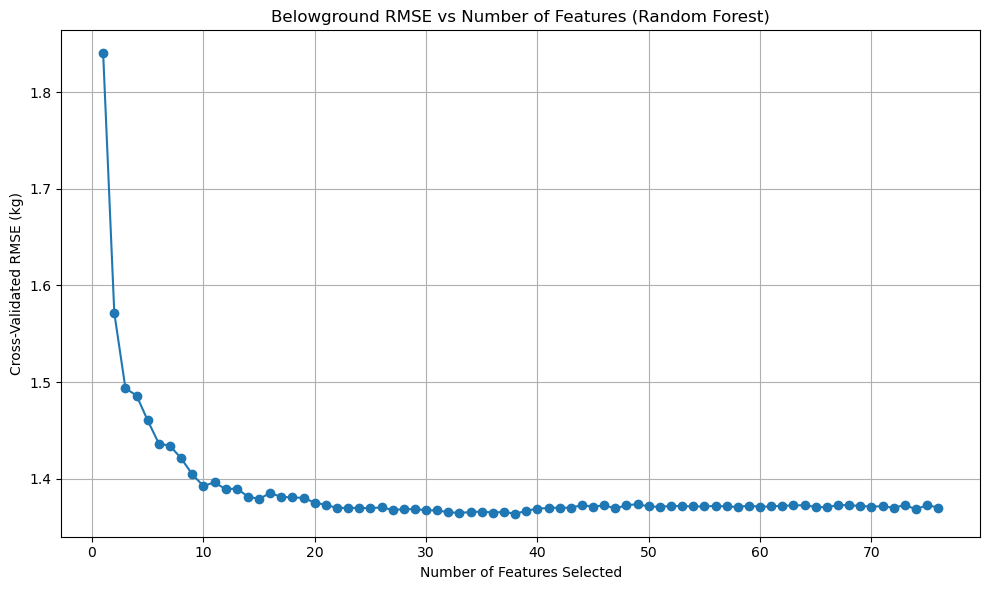

Optimal number of features: 1
Selected features: ['rdnbr']

Top 10 most important features (full model):
1. rdnbr (importance: 0.1739)
2. greenness (importance: 0.0454)
3. CNA_Rad_5_8 (importance: 0.0446)
4. Tree.cover (importance: 0.0365)
5. brightness (importance: 0.0358)
6. TWI (importance: 0.0279)
7. NDII (importance: 0.0277)
8. slope (importance: 0.0270)
9. BD_30 (importance: 0.0258)
10. Silt_30 (importance: 0.0248)


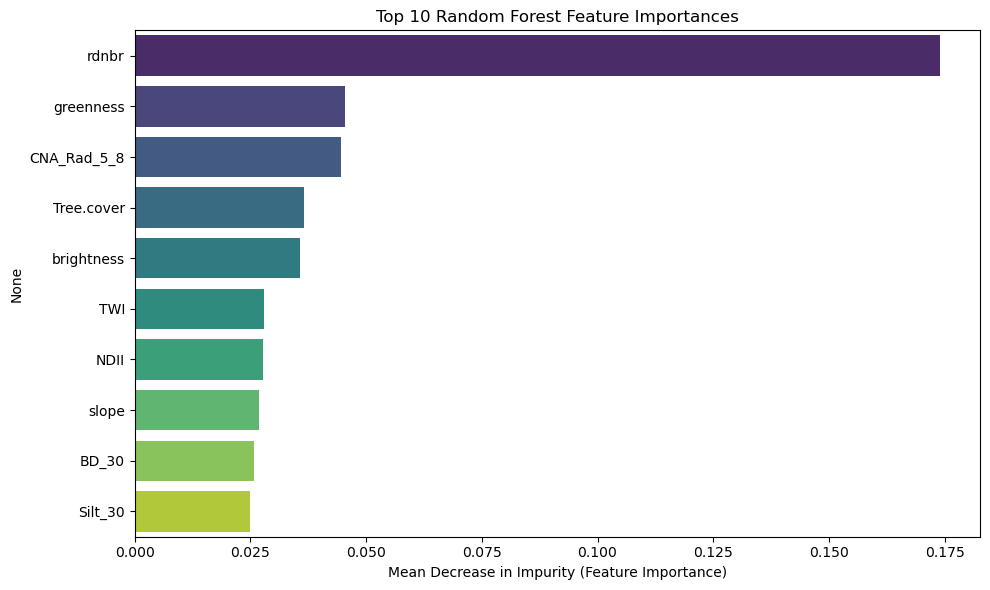

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

# 1. Load and clean data
df = pd.read_csv("/Users/spotter/Documents/new_combustion/2025-06-23_LC_FISL_Original_combustionModelPredictors.csv")

# 2. Exclude columns not relevant for modeling
exclude_columns = [
    'above.carbon.combusted',
    'burn.depth',
    'burn_year',
    'project.name',
    'latitude',
    'longitude',
    'Date',
    'id',
    'CNA_MAR'
]

# 3. Drop excluded columns and NaNs
df_clean = df.drop(columns=exclude_columns).dropna()

# 4. Define target (y) and predictors (X) — exclude y from X
y = df_clean['below.ground.carbon.combusted'] / 1000  # g to kg
X = df_clean.drop(columns=['below.ground.carbon.combusted'])

# 5. Set up scorer and model
rmse_scorer = make_scorer(mean_squared_error, squared=False)
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 6. Run RFECV
rfecv = RFECV(estimator=rf, step=1, cv=cv, scoring=rmse_scorer, n_jobs=-1)
rfecv.fit(X, y)

# 7. Plot CV RMSE vs number of features
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    rfecv.cv_results_['mean_test_score'],
    marker='o'
)
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validated RMSE (kg)")
plt.title("Belowground RMSE vs Number of Features (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Print optimal features
selected_features = list(X.columns[rfecv.support_])
print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", selected_features)

# 9. Train full model to get top 10 global feature importances
full_rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
full_rf.fit(X, y)
full_importances = pd.Series(full_rf.feature_importances_, index=X.columns)
top_10_features = full_importances.sort_values(ascending=False).head(10)

# Print top 10
print("\nTop 10 most important features (full model):")
for i, (name, value) in enumerate(top_10_features.items(), 1):
    print(f"{i}. {name} (importance: {value:.4f})")

# 10. Create a new DataFrame with only the top 10 features
top_10_df_below = X[top_10_features.index].copy()

# 11. Plot top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette="viridis")
plt.xlabel("Mean Decrease in Impurity (Feature Importance)")
plt.title("Top 10 Random Forest Feature Importances")
plt.tight_layout()
plt.show()


Belowground SHAP

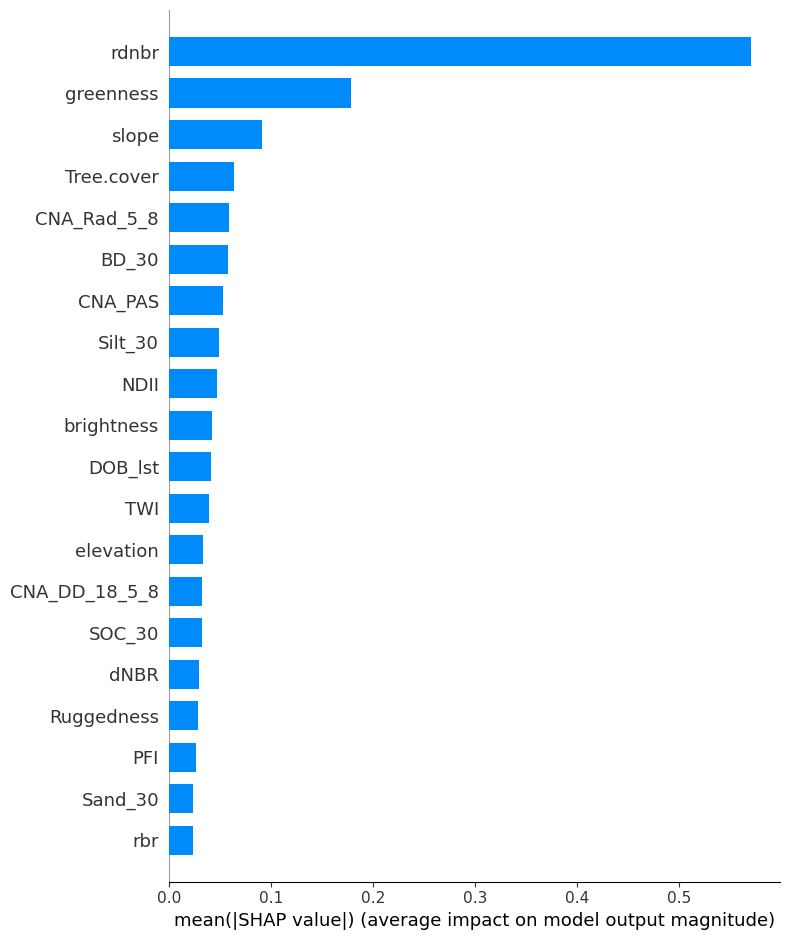

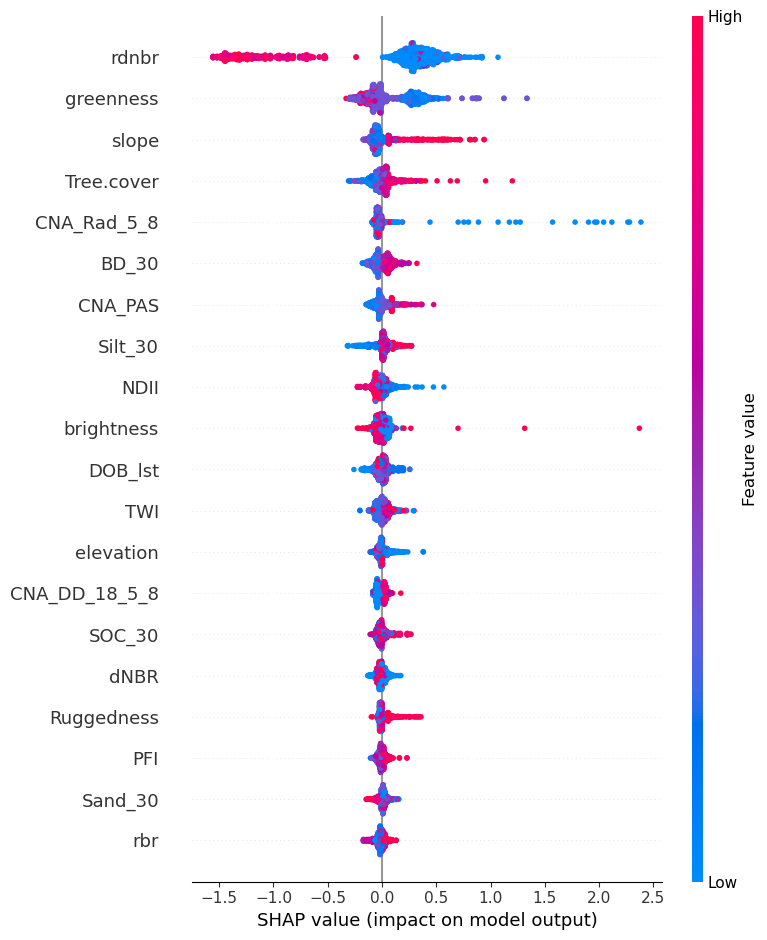

In [22]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 1. Load and clean data
df = pd.read_csv("/Users/spotter/Documents/new_combustion/2025-06-23_LC_FISL_Original_combustionModelPredictors.csv")
exclude_columns = [
    'above.carbon.combusted',
    'burn.depth',
    'burn_year',
    'project.name',
    'latitude',
    'longitude',
    'Date',
    'id',
    'CNA_MAR'
]
df_clean = df.drop(columns=exclude_columns).dropna()

# 2. Split into X and y
y = df_clean['below.ground.carbon.combusted'] / 1000  # g to kg
X = df_clean.drop(columns=['below.ground.carbon.combusted'])

# 3. Fit Random Forest model
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(X, y)

# 4. Initialize SHAP explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

# 5. SHAP summary plot (bar for global importance)
shap.summary_plot(shap_values, X, plot_type="bar", show=True)

# 6. SHAP summary plot (beeswarm for interaction direction)
shap.summary_plot(shap_values, X, show=True)


10-fold CV belowground RF

In [29]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error

# Define 10-fold CV and Random Forest model
cv = KFold(n_splits=10, shuffle=True, random_state=42)
model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)

# Perform 10-fold cross-validated predictions
y_cv_pred = cross_val_predict(model, top_10_df_below, y, cv=cv)

# Calculate metrics
cv_rmse = mean_squared_error(y, y_cv_pred, squared=False)
cv_r2 = r2_score(y, y_cv_pred)

cv_rmse, cv_r2

(1.3677204370260014, 0.43153374477613626)

LOOCV

In [39]:
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Use Leave-One-Out Cross-Validation
cv = LeaveOneOut()
model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)

# Perform LOOCV predictions
y_cv_pred = cross_val_predict(model, top_10_df_below, y, cv=cv)

# Compute metrics
cv_rmse = mean_squared_error(y, y_cv_pred, squared=False)
cv_r2 = r2_score(y, y_cv_pred)

print(f"LOOCV RMSE: {cv_rmse:.3f} kg")
print(f"LOOCV R²: {cv_r2:.3f}")


LOOCV RMSE: 1.357 kg
LOOCV R²: 0.440


10-fold CV belowground Xgboost

In [38]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'n_estimators': [500]
}

# Initialize model and CV
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Fit
grid_search.fit(top_10_df_below, y)

# Best result
best_rmse = -grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best RMSE: {best_rmse:.3f}")
print("Best Parameters:", best_params)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score

# 10-fold CV for R² using the best model
cv = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores = cross_val_score(
    grid_search.best_estimator_,
    top_10_df_below,
    y,
    scoring='r2',
    cv=cv,
    n_jobs=-1
)

print(f"10-Fold CV R²: {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")


/Users/spotter/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/spotter/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/spotter/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/spotter/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version.

Best RMSE: 1.349
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 1.0}
10-Fold CV R²: 0.427 ± 0.117


/Users/spotter/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/spotter/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/spotter/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/spotter/anaconda3/envs/streamlit/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version.